# Notes for "Deep Learning for Portfolio Optimization"

Reference Paper: [Deep Learning for Portfolio Optimization](https://arxiv.org/abs/2005.13665)

---

In [1]:
import omega as o
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
start = '2020-01-01'
end = '2023-01-01'

indices = ['VTI', 'AGG', 'DBC', '^VIX']
prices = o.Ticker(indices).bulk_prices(start, end)

In [7]:
window = 252
rfr = .02

features_dict = {
    'RoC': o.factor.RoC(window=window),
    'MovingSharpe': o.factor.MovingSharpe(window=window, rfr=rfr),
}

pipeline = o.pipeline.Pipeline()
pipeline.add(features_dict)
features = pipeline.run(prices)
prices[window:].stack()
pd.concat([features, ])

RoC  MovingSharpe           0
Date       Equity                                    
2020-12-31 VTI     0.200781      0.206591         NaN
           AGG     0.071804      0.128401         NaN
           DBC    -0.079524      0.290365         NaN
           ^VIX    0.824378     -0.010848         NaN
2021-01-04 VTI     0.191273     -0.660671         NaN
...                     ...           ...         ...
2022-12-29 ^VIX         NaN           NaN   21.440001
2022-12-30 VTI          NaN           NaN  189.699951
           AGG          NaN           NaN   95.276382
           DBC          NaN           NaN   24.650000
           ^VIX         NaN           NaN   21.670000

[4032 rows x 3 columns]

In [8]:
prices[window:].stack()

Date            
2020-12-31  VTI     187.553528
            AGG     111.509666
            DBC      14.611775
            ^VIX     22.750000
2021-01-04  VTI     184.884369
                       ...    
2022-12-29  ^VIX     21.440001
2022-12-30  VTI     189.699951
            AGG      95.276382
            DBC      24.650000
            ^VIX     21.670000
Length: 2016, dtype: float64

In [26]:
def create_lstm_input(data, prices_data, lookback_window):
    """
    Create input for LSTM network.
    
    Args:
    - data: A DataFrame of daily returns.
    - prices_data: A DataFrame of daily prices.
    - lookback_window: An integer for the lookback window size.
    
    Returns:
    - A 3D numpy array suitable for input to an LSTM network.
    """
    lstm_input = []
    for i in range(lookback_window, len(data)):
        past_returns = data.values[i-lookback_window:i]
        past_prices = prices_data.values[i-lookback_window:i]
        features = np.concatenate([past_returns, past_prices], axis=1)
        lstm_input.append(features)
    return np.array(lstm_input)

def create_lstm_target(data, lookback_window):
    """
    Create target for LSTM network.
    
    Args:
    - data: A DataFrame of daily returns.
    - lookback_window: An integer for the lookback window size.
    
    Returns:
    - A 2D numpy array suitable for the target of an LSTM network.
    """
    lstm_target = []
    for i in range(lookback_window, len(data)):
        lstm_target.append(data.values[i])
    return np.array(lstm_target)

In [29]:
start = '2020-01-01'
end = '2021-01-01'

indices = ['VTI', 'AGG', 'DBC', '^VIX']

prices = o.Ticker(indices).bulk_prices(start, end)
returns = np.log(prices).diff()[1:]
prices = prices[1:]

lookback_window = 50
lstm_input = create_lstm_input(returns, prices, lookback_window) # (202, 50 8)
lstm_target = create_lstm_target(returns, lookback_window) # (202, 4)

class PortfolioOptimizationNetwork(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(PortfolioOptimizationNetwork, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        lstm_out_last_time_step = lstm_out[:, -1, :]
        fc_out = self.fc(lstm_out_last_time_step)
        output = self.softmax(fc_out)
        return output

input_dim = lstm_input.shape[-1] # number of features
hidden_dim = 50
output_dim = lstm_target.shape[-1] # number of indices

model = PortfolioOptimizationNetwork(input_dim, hidden_dim, output_dim)

# Split data into training and test sets
train_size = int(0.8 * len(lstm_input))
test_size = len(lstm_input) - train_size

train_input = lstm_input[:train_size]
train_target = lstm_target[:train_size]

test_input = lstm_input[train_size:]
test_target = lstm_target[train_size:]

# (train_input.shape, train_target.shape, test_input.shape, test_target.shape) = ((161, 50, 8), (161, 4), (41, 50, 8), (41, 4))

# Convert numpy arrays to PyTorch tensors
train_input_torch = torch.tensor(train_input, dtype=torch.float32)
train_target_torch = torch.tensor(train_target, dtype=torch.float32)

test_input_torch = torch.tensor(test_input, dtype=torch.float32)
test_target_torch = torch.tensor(test_target, dtype=torch.float32)

# Define the optimizer
optimizer = torch.optim.Adam(model.parameters())

def sharpe_ratio(outputs, targets):
    # Calculate the mean returns
    mean_returns = targets.mean(dim=0)
    
    # Calculate the covariance matrix of the returns
    cov_matrix = torch.tensor(np.cov(targets.T.cpu().numpy()), dtype=torch.float32)
    
    # Calculate the portfolio mean return
    portfolio_mean_return = (outputs * mean_returns).sum(dim=1).mean() * 252
    
    # Calculate the portfolio standard deviation
    portfolio_std = torch.sqrt((outputs @ cov_matrix.to(outputs.device) @ outputs.T).diag().mean()) * np.sqrt(252)
    
    # Calculate the Sharpe ratio
    return portfolio_mean_return / portfolio_std

# Define the number of epochs
epochs = 100

# Train the model
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    # Forward pass
    outputs = model(train_input_torch)
    # Calculate loss (negative Sharpe ratio)
    loss = -sharpe_ratio(outputs, train_target_torch)
    # Backward pass and optimize
    loss.backward()
    optimizer.step()
    if (epoch+1) % 10 == 0:
        print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item()}')

Epoch 10/100, Loss: -1.3527179956436157
Epoch 20/100, Loss: -1.6456549167633057
Epoch 30/100, Loss: -1.7819712162017822
Epoch 40/100, Loss: -1.8191465139389038
Epoch 50/100, Loss: -1.8389257192611694
Epoch 60/100, Loss: -1.8602129220962524
Epoch 70/100, Loss: -1.8866658210754395
Epoch 80/100, Loss: -1.8981270790100098
Epoch 90/100, Loss: -1.902238368988037
Epoch 100/100, Loss: -1.9039934873580933


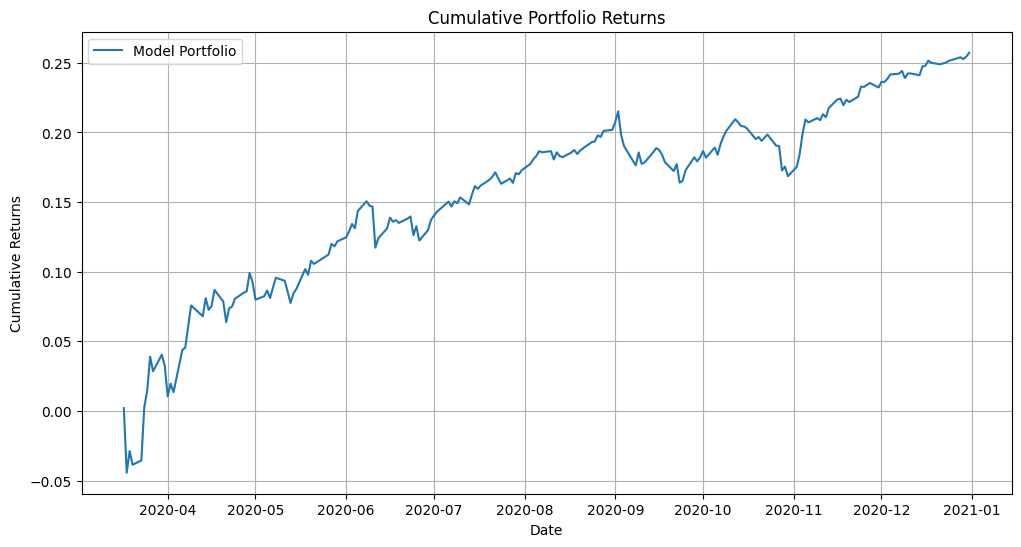

In [33]:
# Concatenate training and test sets
full_input_torch = torch.tensor(np.concatenate([train_input, test_input]), dtype=torch.float32)
full_target_torch = torch.tensor(np.concatenate([train_target, test_target]), dtype=torch.float32)

# Predict portfolio weights for the entire dataset
model.eval()
with torch.no_grad():
    full_outputs = model(full_input_torch)

# Calculate portfolio returns
portfolio_returns = (full_outputs * full_target_torch).sum(dim=1)

# Calculate cumulative portfolio returns
cumulative_portfolio_returns = (portfolio_returns + 1).cumprod(dim=0) - 1

# Plot the cumulative portfolio returns
plt.figure(figsize=(12, 6))
plt.plot(prices.index[lookback_window:], cumulative_portfolio_returns.cpu().numpy(), label='Model Portfolio')
plt.title('Cumulative Portfolio Returns')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.grid(True)
plt.show()


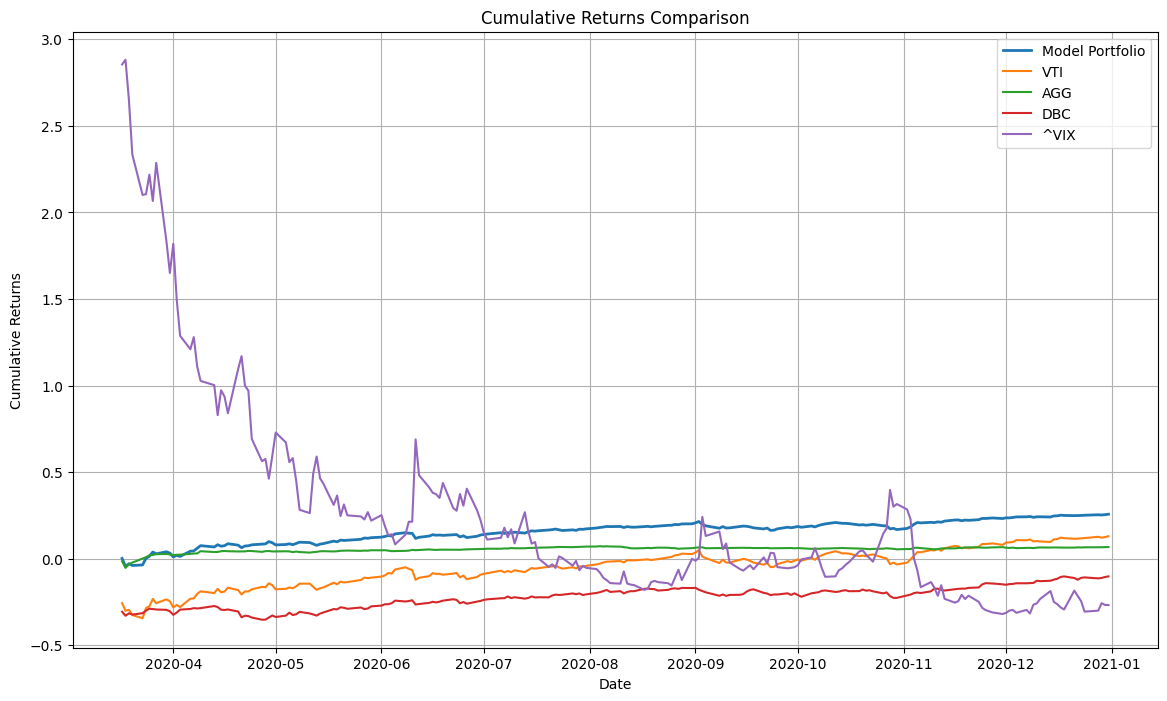

In [38]:
# Calculate the cumulative returns for the individual assets
individual_cumulative_returns = (returns + 1).cumprod() - 1

# Plot the cumulative portfolio returns (model's portfolio)
plt.figure(figsize=(14, 8))
plt.plot(prices.index[lookback_window:], cumulative_portfolio_returns.cpu().numpy(), label='Model Portfolio', linewidth=2)

# Plot the cumulative returns for the individual assets
for column in individual_cumulative_returns.columns:
    plt.plot(individual_cumulative_returns.index[lookback_window:], individual_cumulative_returns[column][lookback_window:], label=column)

plt.title('Cumulative Returns Comparison')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.grid(True)
plt.show()

In [23]:
lstm_target = create_lstm_target(returns, lookback_window)
lstm_target.shape

(202, 4)

In [24]:
class PortfolioOptimizationNetwork(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(PortfolioOptimizationNetwork, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        lstm_out_last_time_step = lstm_out[:, -1, :]
        fc_out = self.fc(lstm_out_last_time_step)
        output = self.softmax(fc_out)
        return output

input_dim = lstm_input.shape[-1] # number of features
hidden_dim = 50
output_dim = lstm_target.shape[-1] # number of indices

model = PortfolioOptimizationNetwork(input_dim, hidden_dim, output_dim)
print(model)

PortfolioOptimizationNetwork(
  (lstm): LSTM(8, 50, batch_first=True)
  (fc): Linear(in_features=50, out_features=4, bias=True)
  (softmax): Softmax(dim=-1)
)


In [25]:
# Split data into training and test sets
train_size = int(0.8 * len(lstm_input))
test_size = len(lstm_input) - train_size

train_input = lstm_input[:train_size]
train_target = lstm_target[:train_size]

test_input = lstm_input[train_size:]
test_target = lstm_target[train_size:]

(train_input.shape, train_target.shape, test_input.shape, test_target.shape)

((161, 50, 8), (161, 4), (41, 50, 8), (41, 4))

In [26]:
# Convert numpy arrays to PyTorch tensors
train_input_torch = torch.tensor(train_input, dtype=torch.float32)
train_target_torch = torch.tensor(train_target, dtype=torch.float32)

test_input_torch = torch.tensor(test_input, dtype=torch.float32)
test_target_torch = torch.tensor(test_target, dtype=torch.float32)

# Define the optimizer
optimizer = torch.optim.Adam(model.parameters())

def sharpe_ratio(outputs, targets):
    # Calculate the mean returns
    mean_returns = targets.mean(dim=0)
    
    # Calculate the covariance matrix of the returns
    cov_matrix = torch.tensor(np.cov(targets.T.cpu().numpy()), dtype=torch.float32)
    
    # Calculate the portfolio mean return
    portfolio_mean_return = (outputs * mean_returns).sum(dim=1).mean() * 252
    
    # Calculate the portfolio standard deviation
    portfolio_std = torch.sqrt((outputs @ cov_matrix.to(outputs.device) @ outputs.T).diag().mean()) * np.sqrt(252)
    
    # Calculate the Sharpe ratio
    return portfolio_mean_return / portfolio_std

# Define the number of epochs
epochs = 100

# Train the model
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    # Forward pass
    outputs = model(train_input_torch)
    
    # Calculate loss (negative Sharpe ratio)
    loss = -sharpe_ratio(outputs, train_target_torch)
    
    # Backward pass and optimize
    loss.backward()
    optimizer.step()
    
    if (epoch+1) % 10 == 0:
        print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item()}')

Epoch 10/100, Loss: -1.038583517074585
Epoch 20/100, Loss: -1.648177146911621
Epoch 30/100, Loss: -1.8167041540145874
Epoch 40/100, Loss: -1.8668265342712402
Epoch 50/100, Loss: -1.8876171112060547
Epoch 60/100, Loss: -1.8965784311294556
Epoch 70/100, Loss: -1.8999032974243164
Epoch 80/100, Loss: -1.9018139839172363
Epoch 90/100, Loss: -1.903157353401184
Epoch 100/100, Loss: -1.9043278694152832


In [27]:
outputs

tensor([[0.3865, 0.5884, 0.0223, 0.0028],
        [0.3926, 0.5823, 0.0223, 0.0028],
        [0.3901, 0.5848, 0.0223, 0.0028],
        [0.3924, 0.5825, 0.0223, 0.0028],
        [0.3935, 0.5813, 0.0224, 0.0028],
        [0.3946, 0.5802, 0.0225, 0.0028],
        [0.3965, 0.5784, 0.0224, 0.0028],
        [0.3960, 0.5789, 0.0224, 0.0028],
        [0.3980, 0.5769, 0.0224, 0.0027],
        [0.3961, 0.5788, 0.0224, 0.0028],
        [0.3988, 0.5761, 0.0224, 0.0027],
        [0.3993, 0.5756, 0.0224, 0.0027],
        [0.3980, 0.5769, 0.0224, 0.0028],
        [0.3996, 0.5753, 0.0224, 0.0027],
        [0.4001, 0.5746, 0.0225, 0.0028],
        [0.4006, 0.5743, 0.0224, 0.0027],
        [0.4004, 0.5745, 0.0224, 0.0027],
        [0.4009, 0.5740, 0.0224, 0.0027],
        [0.4011, 0.5738, 0.0224, 0.0027],
        [0.4011, 0.5738, 0.0224, 0.0027],
        [0.4013, 0.5735, 0.0224, 0.0027],
        [0.4011, 0.5737, 0.0224, 0.0027],
        [0.4012, 0.5737, 0.0224, 0.0027],
        [0.4013, 0.5736, 0.0224, 0

In [15]:
te

161